# Dataset Generation Notebook

## Load the necessary libraries

In [1]:
import numpy as np
import cv2 as cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
import os
import pandas as pd
from scripts.data import prepare_data
from sklearn.model_selection import train_test_split 
import tensorflow as tf 

## Load images from the train images folder

In [2]:
def load_images_from_directory(directory):
    ''' To load images from a directory.
    
    Paramaeters
    -----------
    directory
        The directory which has the stored images
    
    Returns
    -------
    images: list
        List of loaded images
    filenames: list
        List of filenames of loaded images
        
    '''
    
    images = []
    filenames = []
    
    # Loop through all the images in a given directory
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory,filename),0)
        if img is not None:
            images.append(img)
            filenames.append('/cdtemp/dheerajr/Images-Test/' + filename)
            
    return images, filenames

In [4]:
# Load the images required to form the dataset
images,filenames = load_images_from_directory('/cdtemp/dheerajr/Images-Train/')

In [5]:
def unpackOctave(keypoint):
    ''' To extract octave, layer, and scale of a keypoint.
    
    Unpacks octave, layer, and scale using the pyramid octave in which the keypoint has been detected from
    keypoint class of SIFT.
    
    Parameters
    ----------
    keypoint
        Computed SIFT keypoint
        
    Returns
    -------
    octave
        Masked octave in which the keypoint has been detected
    layer
        Layer in which the keypoint is detected
    scale
        Scale of the keypoint.
        
    '''
     
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float(1 << octave) if octave >= 0 else float(1 << -octave)
    return octave, layer, scale

In [6]:
def df_hist_filtered_one(df):
    ''' Filters an input dataframe of one image as a function of keypoint size frequencies
    
    First, computes a histogram based on the keypoint sizes in the dataframe. For the first & second bin of 
    keypoints, extracts 20 keypoints randomly.
    
    Parameters
    ----------
    df
        Input Dataframe of one image to be histogram filtered.
        
    Returns
    -------
    df_fil
        Dataframe with filtered keypoints and their corresponding information.
    
    Raises
    ------
    IndexError
        For some inbetween bins of keypoint sizes in an image exists no keypoints. Ignore those bins.
    ValueError
        For some inbetween bins of keypoint sizes in an image exists no keypoints. Ignore those bins.
    '''
    hist, bin_edges = np.histogram(df['Keypoint Size']) # compute histogram of keypoint sizes
    df_fil = pd.DataFrame() # instantiate a new dataframe to store the filtered keypoints
    
    # Loop over all the different bins of keypoint sizes found in a dataframe
    for i in range(len(bin_edges)):        
        ''' From all the bins, 20 random keypoints are selected in order to create a balanced dataset. 
        If there are bins with less than 20 keypoints, some of the keypoints are repeated to have an evenly 
        spaced distribution of keypoint sizes among all keypoints.
        
        It is important to note that not all sizes are not available from an image and some bins of sizes
        can remain unfilled. In such cases, an IndexError is raised which ignores that bin.
        
        ''' 
        
        try:
                    
                df_one = df[df['Keypoint Size'].between(bin_edges[i], bin_edges[i+1])] # select keypoints between
                                                                                    # two bins of keypoint sizes
                df_one = df_one.sample(n=20, replace=True) # select 20 keypoints 
                df_fil = pd.concat([df_fil, df_one]) # concatenate to the new dataframe
        except ValueError:
                pass  # as decribed in the docstring
        except IndexError:
                pass  # as decribed in the docstring
    

    return df_fil # returns the filtered dataframe

In [7]:
def df_hist_filtered(images, filenames):
    ''' To create a dataframe of keypoints for a set of images which are histogram filtered.
    
    Applies histogram filtering as defined in df_hist_filtered_one(df) for a set of images and
    creates the final dataframe to be exported.
    
    Parameters
    ----------
    images: list
        List of images.
    filenames: list
        List of image filepaths.    
        
    Returns
    -------
    df_fin
        Dataframe with filtered keypoints and their corresponding information.
        
    '''
    
    df_fin = pd.DataFrame() # instantiate a new dataframe to store the filtered keypoints
    
    # Loop over all the images from the list
    for i in range(len(images)):
        df_one = sift_features_dataframe(images[i:i+1], filenames[i:i+1]) # calls the function to extract 
                                                                        # SIFT keypoints for one image
        df_fil = df_hist_filtered_one(df_one) # calls the function to filter the keypoints for one image
        df_fin = pd.concat([df_fin, df_fil], ignore_index=True) # concatenate to the new dataframe
        
    return df_one, df_fin # returns the filtered dataframe of keypoints ready to be exported.

In [8]:
len(images)

5093

In [9]:
# Select a subset of images to form the dataset
images_train= images[0:100]
filenames_train = filenames[0:100]

In [10]:
def sift_features_dataframe(img_list, filename_list,patch_width=20):
    ''' To extract SIFT keypoints and their corresponding information
    
    Applies SIFT to a set of images and store all the keypoint information (filename, position, 
    orientation, scale, size, and octave) as a Pandas Dataframe. 
    
    Parameters
    ----------
    img_list: list
        List of images.
    filename_list: list
        List of image filepaths.    
    patch_width: int
        Size of the patches to be computed.
        
    Returns
    -------
    df
        Dataframe with all keypoints and their corresponding information.
        
    '''

    kp_list = [] # all keypoints
    
    # Initialization of lists to store all relevant keypoint information for a set of images   
    kp_scale = [] 
    kp_angle = []
    kp_coordinate = []
    kp_octave = []
    kp_size = []
    kp_filename = []
    
    # Loop over all images from the image list
    for img in range(len(img_list)):
        kp1 = [] # empty list to store all keypoints for an image
        desc1 = [] # empty list to store all descriptors for an image
        
        # Initialization for one image        
        image = img_list[img] # load an image
        filename = filename_list[img] # load the filepath of the image
        sift = cv2.SIFT_create()  # create SIFT object       
        kp1, desc1 = sift.detectAndCompute(image, None)  # detect SIFT keypoints and compute descriptors
        
        # For every keypoint in an image, obtain respective parameters
        for kp in kp1:
            cord = tuple(np.round(kp.pt).astype(int)) # round float keypoint position to a tuple of integer                 
            octave, layer, scale = unpackOctave(kp) # unpack these paramters using keypoint's octave
            # Append all parameters to respective lists
            kp_scale.append(scale) 
            kp_angle.append(kp.angle)
            kp_coordinate.append(tuple(np.round(kp.pt).astype(int)))
            kp_octave.append(octave)
            kp_size.append(kp.size)
            kp_filename.append(filename)
            
    # Construct a dictionary with all extracted information
    data_dict = {'Filename':kp_filename,'Co-ordinates':kp_coordinate,
                 'Characteristic Orientation':kp_angle,'Octave':kp_octave,'Keypoint Size':kp_size}
    
    # Convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    
    return df # returns a pandas dataframe with all the keypoint information

In [17]:
def surf_features_dataframe(img_list, filename_list,patch_width=20):
    ''' To extract SURF keypoints and their corresponding information
    
    Applies SURF to a set of images and store all the keypoint information (filename, position, 
    orientation, scale, size, and octave) as a Pandas Dataframe. 
    
    Parameters
    ----------
    img_list: list
        List of images.
    filename_list: list
        List of image filepaths.    
    patch_width: int
        Size of the patches to be computed.
        
    Returns
    -------
    df
        Dataframe with all keypoints and their corresponding information.
        
    '''

    kp_list = [] # all keypoints
    
    # Initialization of lists to store all relevant keypoint information for a set of images   
    kp_scale = [] 
    kp_angle = []
    kp_coordinate = []
    kp_octave = []
    kp_size = []
    kp_filename = []
    
    # Loop over all images from the image list
    for img in range(len(img_list)):
        kp1 = [] # empty list to store all keypoints for an image
        desc1 = [] # empty list to store all descriptors for an image
        
        # Initialization for one image        
        image = img_list[img] # load an image
        filename = filename_list[img] # load the filepath of the image
        surf = cv2.xfeatures2d.SURF_create()  # create SIFT object    
        surf.setHessianThreshold(1000)
        kp1, desc1 = surf.detectAndCompute(image, None)  # detect SIFT keypoints and compute descriptors
        
        # For every keypoint in an image, obtain respective parameters
        for kp in kp1:
            cord = tuple(np.round(kp.pt).astype(int)) # round float keypoint position to a tuple of integer                 
            octave, layer, scale = unpackOctave(kp) # unpack these paramters using keypoint's octave
            # Append all parameters to respective lists
            kp_scale.append(scale) 
            kp_angle.append(kp.angle)
            kp_coordinate.append(tuple(np.round(kp.pt).astype(int)))
            kp_octave.append(octave)
            kp_size.append(kp.size)
            kp_filename.append(filename)
            
    # Construct a dictionary with all extracted information
    data_dict = {'Filename':kp_filename,'Co-ordinates':kp_coordinate,
                 'Characteristic Orientation':kp_angle,'Octave':kp_octave,'Keypoint Size':kp_size}
    
    # Convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    
    return df # returns a pandas dataframe with all the keypoint information

In [17]:
# Call the function to obtain the dataframe of filtered keypoints and export it on to the disk.
#df_full, df_fil = df_hist_filtered(images_train, filenames_train)
df_fil = sift_features_dataframe(images_train[0:50], filenames_train[0:50])

In [62]:
df_fil

,Filename,Co-ordinates,Characteristic Orientation,Octave,Keypoint Size
0,/cdtemp/dheerajr/Images-Test/2008_002961.jpg,"(82, 267)",100.983658,-1,1.795965
1,/cdtemp/dheerajr/Images-Test/2008_008589.jpg,"(338, 110)",49.525490,-1,1.795970
2,/cdtemp/dheerajr/Images-Test/2008_002961.jpg,"(293, 245)",272.185242,-1,1.795980
3,/cdtemp/dheerajr/Images-Test/2008_004647.jpg,"(273, 343)",335.709534,-1,1.795994
4,/cdtemp/dheerajr/Images-Test/2008_006732.jpg,"(180, 82)",270.686218,-1,1.796017
...,...,...,...,...,...
47850,/cdtemp/dheerajr/Images-Test/2008_000253.jpg,"(195, 127)",228.360123,4,111.085587
47851,/cdtemp/dheerajr/Images-Test/2008_003001.jpg,"(173, 239)",189.185211,4,112.903625
47852,/cdtemp/dheerajr/Images-Test/2008_003001.jpg,"(173, 239)",97.296486,4,112.903625
47853,/cdtemp/dheerajr/Images-Test/2008_004430.jpg,"(314, 200)",324.975769,4,113.035851


In [67]:
df_fil = df_fil.sort_values(by='Keypoint Size').reset_index(drop=True)
df_fil = df_fil.drop_duplicates()
df_fil_hist

,Filename,Co-ordinates,Characteristic Orientation,Octave,Keypoint Size
0,/cdtemp/dheerajr/Images-Test/2008_002961.jpg,"(82, 267)",100.983658,-1,1.795965
1,/cdtemp/dheerajr/Images-Test/2008_008589.jpg,"(338, 110)",49.525490,-1,1.795970
2,/cdtemp/dheerajr/Images-Test/2008_002961.jpg,"(293, 245)",272.185242,-1,1.795980
3,/cdtemp/dheerajr/Images-Test/2008_004647.jpg,"(273, 343)",335.709534,-1,1.795994
4,/cdtemp/dheerajr/Images-Test/2008_006732.jpg,"(180, 82)",270.686218,-1,1.796017
...,...,...,...,...,...
46995,/cdtemp/dheerajr/Images-Test/2008_004280.jpg,"(321, 175)",255.010864,2,19.233570
46996,/cdtemp/dheerajr/Images-Test/2008_004280.jpg,"(321, 175)",214.065536,2,19.233570
46997,/cdtemp/dheerajr/Images-Test/2008_004428.jpg,"(63, 191)",292.494537,2,19.257839
46998,/cdtemp/dheerajr/Images-Test/2008_006811.jpg,"(383, 210)",138.599792,2,19.258554


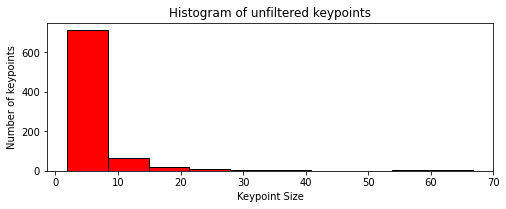

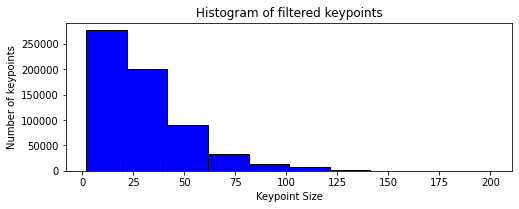

In [45]:
plt.figure(figsize=(8, 6)) 
plt.subplot(2,1,1), 
plt.hist(df_full['Keypoint Size'], color='red', edgecolor='black');
plt.xlabel('Keypoint Size'), plt.ylabel('Number of keypoints'), plt.title('Histogram of unfiltered keypoints');
plt.figure(figsize=(8, 6)) 
plt.subplot(2,1,2), 
plt.hist(df_fil['Keypoint Size'], color='blue', edgecolor='black');
plt.xlabel('Keypoint Size'), plt.ylabel('Number of keypoints'), plt.title('Histogram of filtered keypoints');

In [44]:
df_fil.to_json('/cdtemp/dheerajr/Datasets/Train/Train_hist_filt/Train_histfil_4000_20_bin.json',
            orient="records")  # Store the dataset onto the disk
    
#df_test.to_json('/cdtemp/dheerajr/Datasets/Test/Test_100.json',
            #orient="records")  # Store the dataset onto the disk